In [1]:
import cv2
import numpy as np
import glob
import matplotlib

import matplotlib.pyplot as plt

In [2]:
import src.CameraCalibration as cc

## Camera Calibration

total image : 20


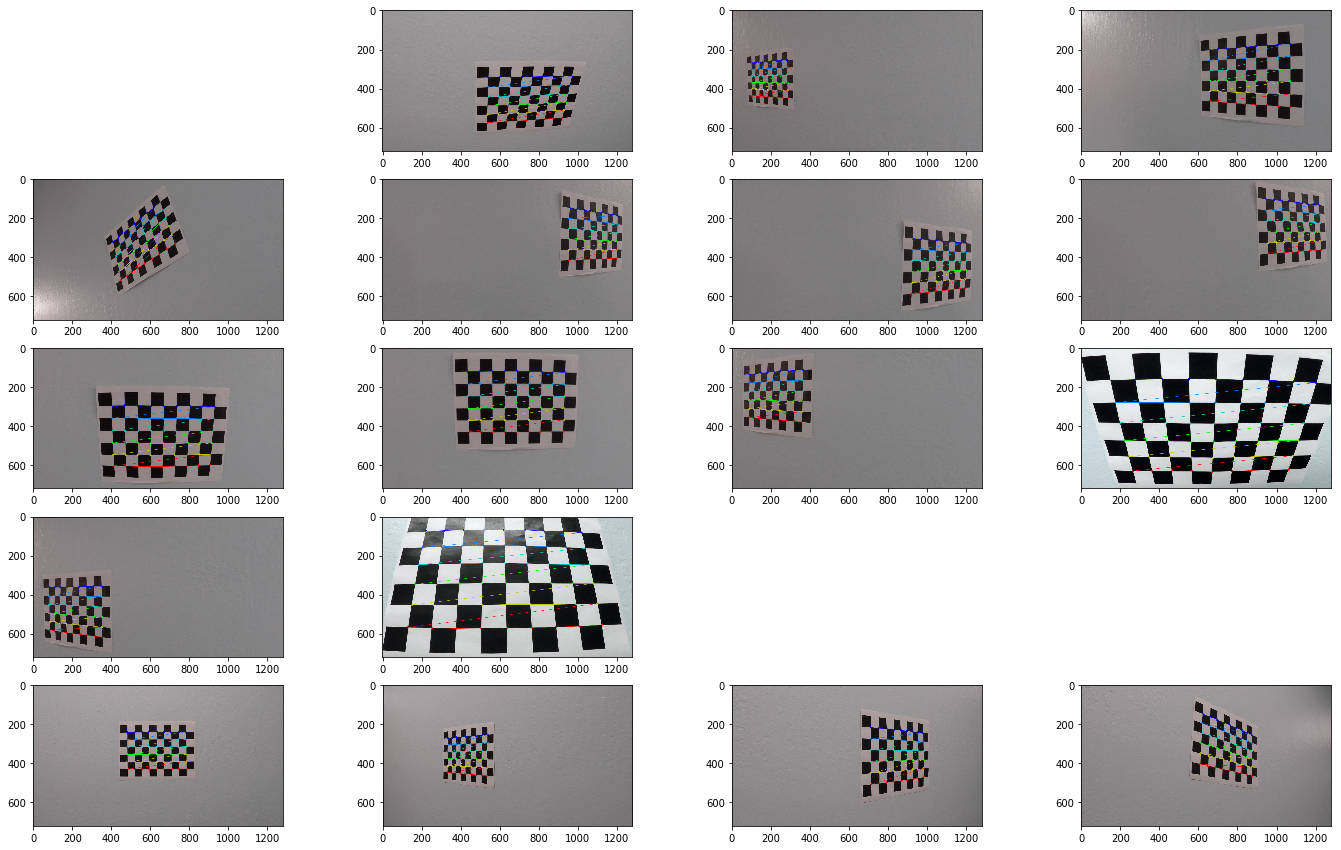

In [3]:
calibration = cc.Calibration('./camera_cal', 'jpg', 9, 6)
calibration.cameraCalibration(_drawCorner = True)

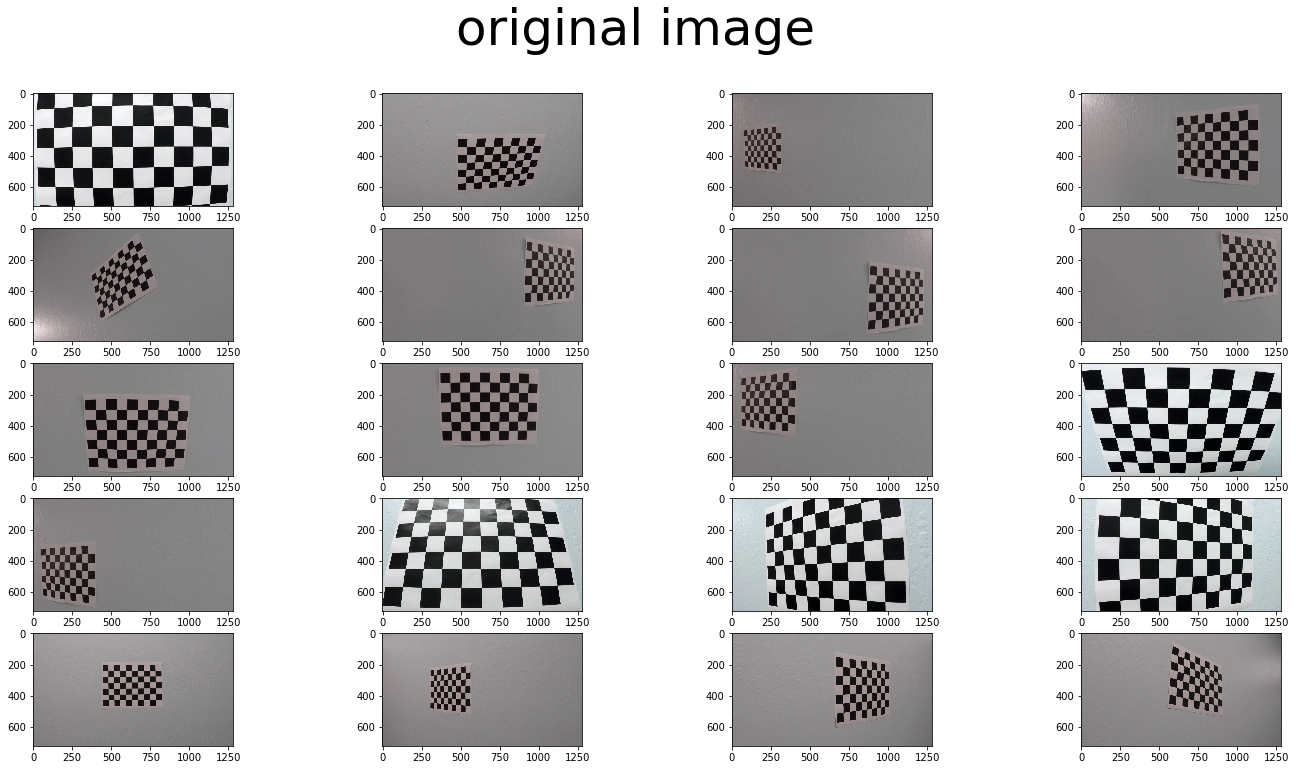

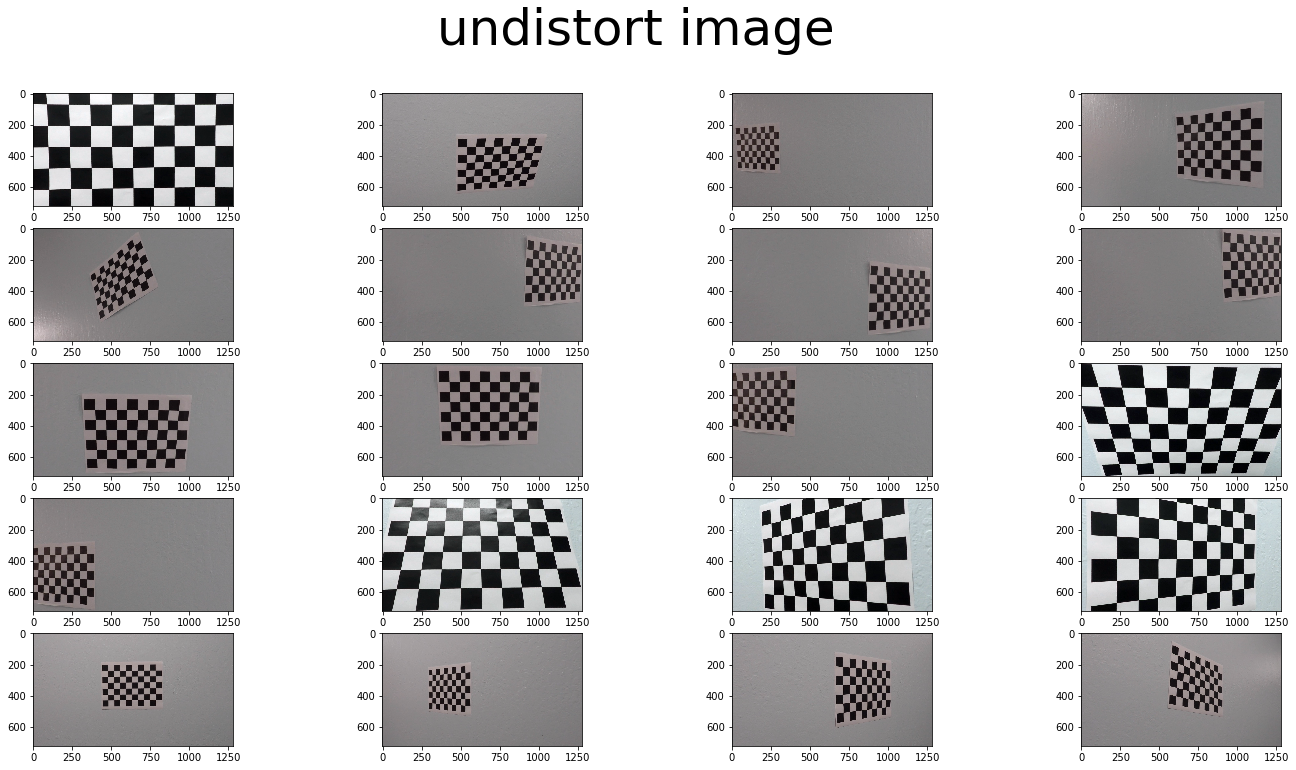

In [4]:
calibration.undistort_list(calibration.getDataList())

In [7]:
test_img_list = glob.glob('./test_images/*.jpg')

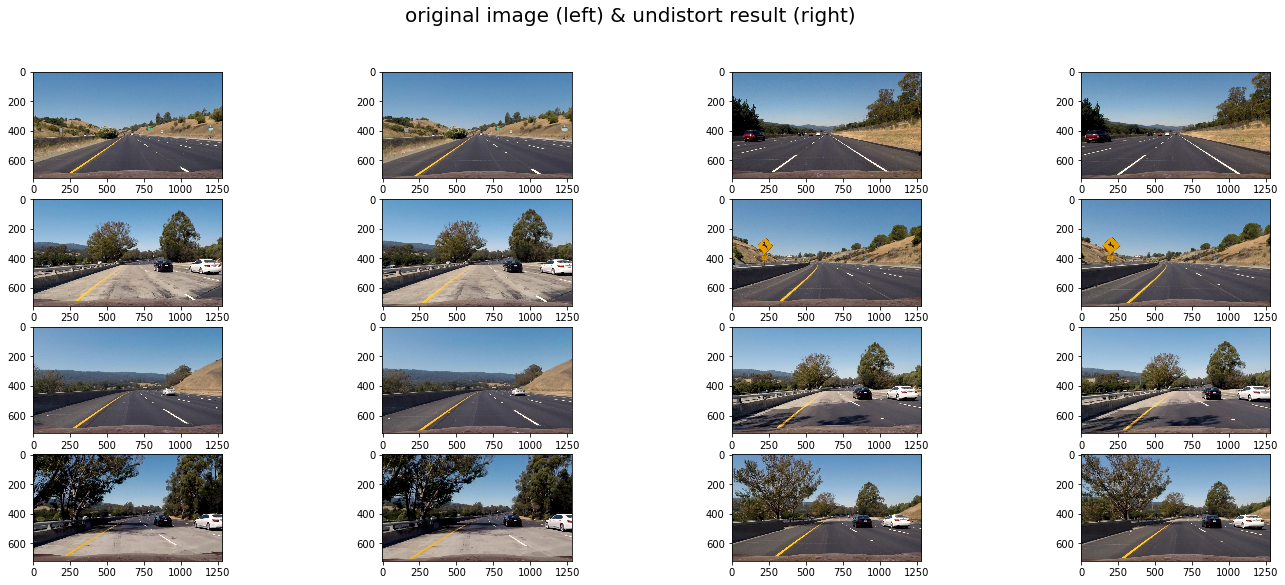

In [8]:
fig_und = plt.figure(figsize=(24, 9))
fig_und.suptitle('original image (left) & undistort result (right)', fontsize=20)
for i, _filename in enumerate(test_img_list) :
    img = cv2.cvtColor(cv2.imread(_filename), cv2.COLOR_BGR2RGB)
    und_img = calibration.undistort(img)
    und = fig_und.add_subplot(4, 4, 2 * i + 1)
    und.imshow(img)
    und = fig_und.add_subplot(4, 4, 2 * i + 2)
    und.imshow(und_img)
plt.show()

# warp

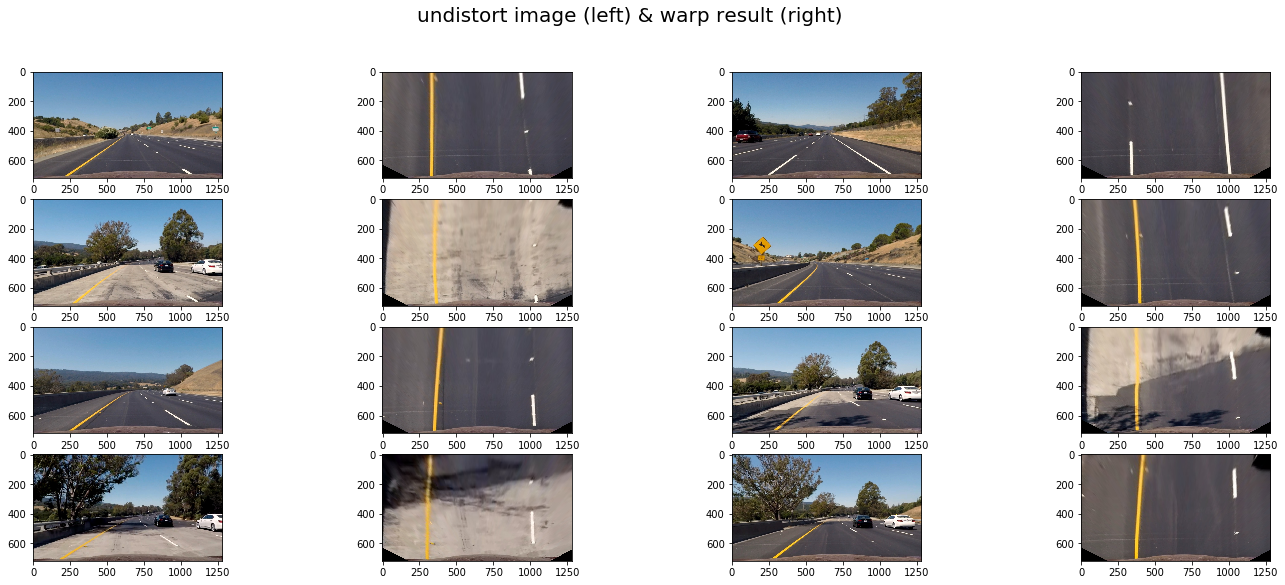

In [44]:
# src_p = np.float32([[535, 490], [770, 490], [1090, 660], [290, 660]])
src_p = np.float32([[535, 490], [770, 490], [1100, 719], [190, 719]])
dst_p = np.float32([[320, 0], [1000, 0], [1000, 720 - 1], [320, 720 - 1]])
M = cv2.getPerspectiveTransform(src_p, dst_p)
# print (test_img_list[4])
# img = cv2.cvtColor(cv2.imread(test_img_list[6]), cv2.COLOR_BGR2RGB)
# und_img = calibration.undistort(img)
# warped = cv2.warpPerspective(und_img, M, (img.shape[1], img.shape[0]))
# plt.imshow(warped)
# f = plt.show()

fig_und = plt.figure(figsize=(24, 9))
fig_und.suptitle('undistort image (left) & warp result (right)', fontsize=20)
for i, _filename in enumerate(test_img_list) :
    img = cv2.cvtColor(cv2.imread(_filename), cv2.COLOR_BGR2RGB)
    und_img = calibration.undistort(img)
    warped = cv2.warpPerspective(und_img, M, (img.shape[1], img.shape[0]))
    und = fig_und.add_subplot(4, 4, 2 * i + 1)
    und.imshow(und_img)
    und = fig_und.add_subplot(4, 4, 2 * i + 2)
    und.imshow(warped)
f = plt.show()


In [10]:
import src.Filters as F

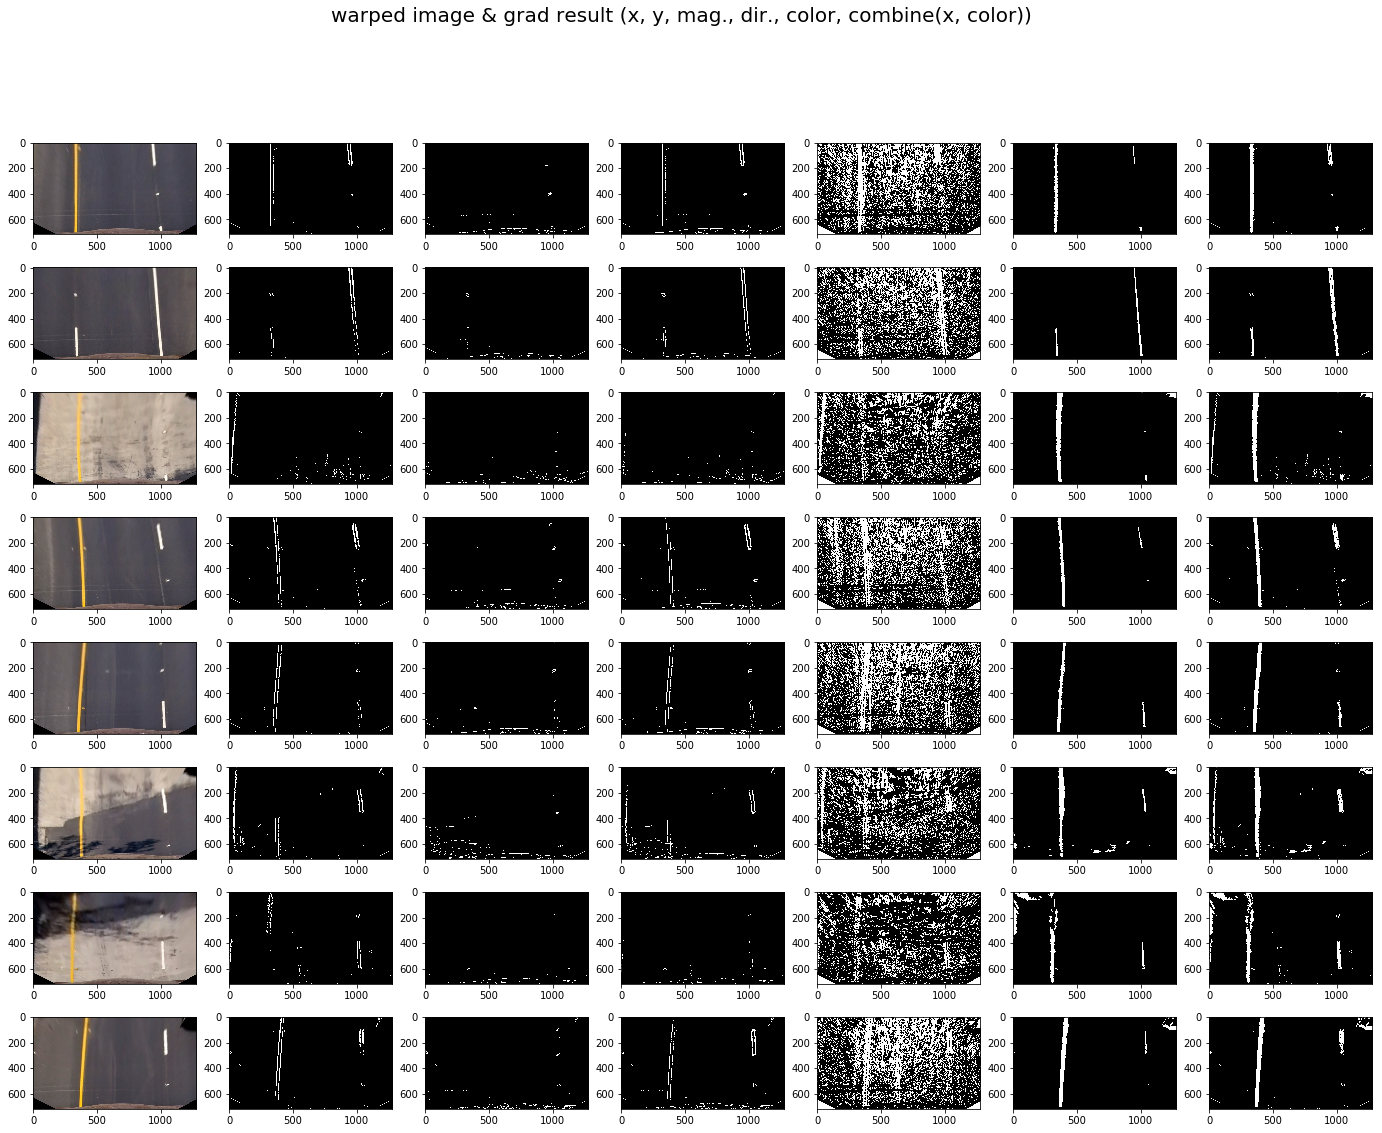

In [45]:
gradF = F.gradFilters(_sobel_x_thresh=(30, 100), 
                    _sobel_y_thresh=(30, 100), 
                    _mag_thresh=(30, 100), 
                    _dir_thresh=(0.0, 0.4))

colorF = F.colorFilter()

fig_und = plt.figure(figsize=(24, 18))
fig_und.suptitle('warped image & grad result (x, y, mag., dir., color, combine(x, color))', fontsize=20)
for i, _filename in enumerate(test_img_list) :
    img = cv2.cvtColor(cv2.imread(_filename), cv2.COLOR_BGR2RGB)
    und_img = calibration.undistort(img)
    warped = cv2.warpPerspective(und_img, M, (img.shape[1], img.shape[0]))
    
    _, _ = gradF.compute_mag_grad(warped, 3)
    _ = gradF.compute_dir(warped, 21)

    xFilter = gradF.getXgradFilter()
    yFilter = gradF.getYgradFilter()
    magFilter = gradF.getMagFilter()
    dirFilter = gradF.getDirFilter()
    
    colorFilter = colorF.getColorFilter(warped, (120, 255))
    
    combine = np.zeros_like(colorFilter)
    combine[(xFilter == 1) | (colorFilter == 1)] = 1
    
    und = fig_und.add_subplot(8, 7, 7 *i + 1)
    und.imshow(warped)
    und = fig_und.add_subplot(8, 7, 7 * i + 2)
    und.imshow(xFilter, cmap='gray')
    und = fig_und.add_subplot(8, 7, 7 * i + 3)
    und.imshow(yFilter, cmap='gray')
    und = fig_und.add_subplot(8, 7, 7 * i + 4)
    und.imshow(magFilter, cmap='gray')
    und = fig_und.add_subplot(8, 7, 7 * i + 5)
    und.imshow(dirFilter, cmap='gray')
    und = fig_und.add_subplot(8, 7, 7 * i + 6)
    und.imshow(colorFilter, cmap='gray')
    und = fig_und.add_subplot(8, 7, 7 * i + 7)
    und.imshow(combine, cmap='gray')
    
f = plt.show()

In [10]:
import src.FindingLane as FLane

In [46]:
finder = Lane()
finder.processing(combine, warped)
# plt.imshow(finder.out_img)
# plt.show()

(0.0, 12440.687352993138)

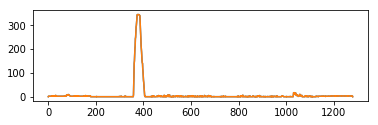

In [31]:
plt.plot(finder.histogram)
plt.show()

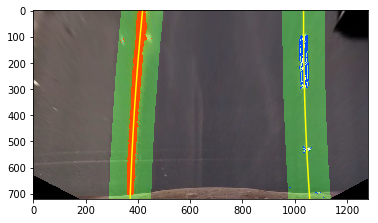

In [47]:
finder.processing(combine, warped, _visualization = True)
plt.imshow(finder.result)
plt.show()

# unwarp

In [33]:
inv_M = cv2.getPerspectiveTransform(dst_p, src_p)
sign_img = np.ones_like(finder.result) * 255
inv_warped = cv2.warpPerspective(finder.result, inv_M, (img.shape[1], img.shape[0]))
inv_sign_img = cv2.warpPerspective(sign_img, inv_M, (img.shape[1], img.shape[0]))

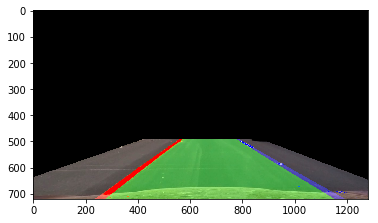

In [34]:
plt.imshow(inv_warped)
plt.show()

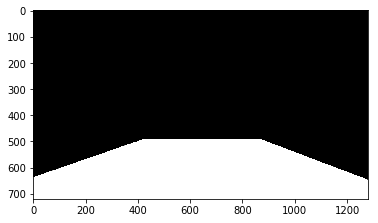

In [49]:
plt.imshow(inv_sign_img)
plt.show()

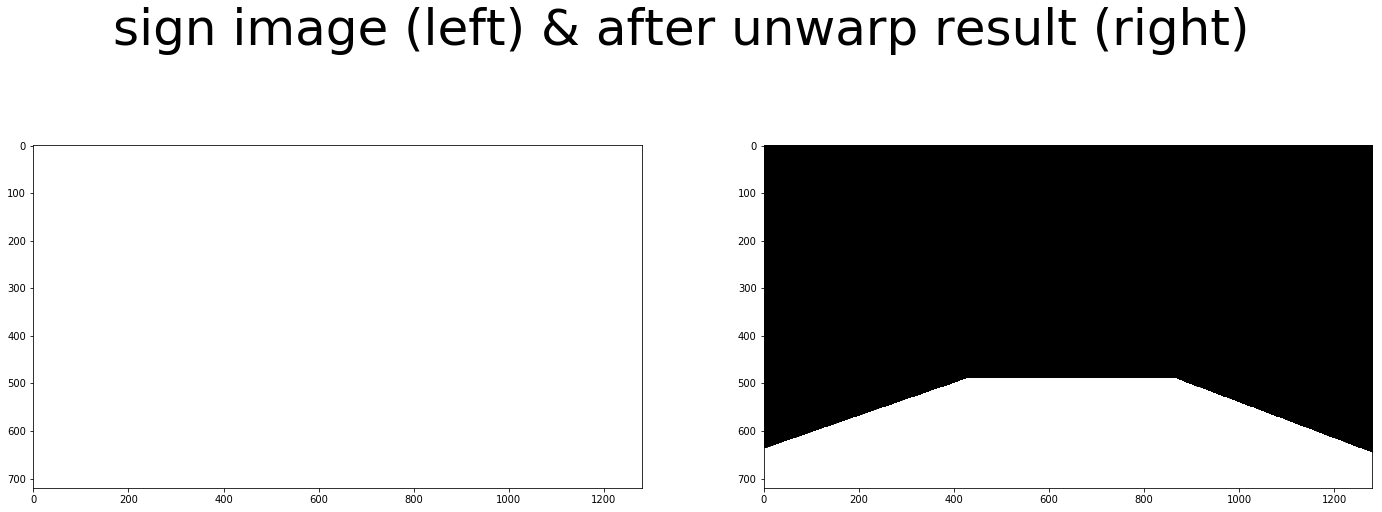

In [51]:
fig_und = plt.figure(figsize=(24, 9))
fig_und.suptitle('sign image (left) & after unwarp result (right)', fontsize=50)

und = fig_und.add_subplot(1, 2, 1)
und.imshow(sign_img)
und = fig_und.add_subplot(1, 2, 2)
und.imshow(inv_sign_img)
f = plt.show()

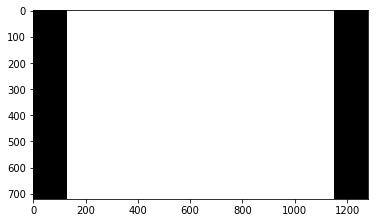

In [45]:
cover = np.zeros_like(xFilter)
cover[:, 130:1150] = 1
plt.imshow(cover, cmap='gray')
plt.show()

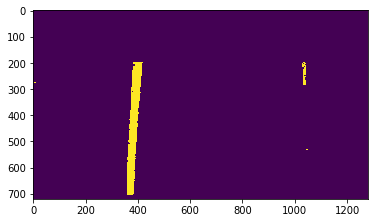

In [43]:
colorFilter_cp = np.copy(colorFilter)
colorFilter_cp[(cover == 0)] = 0
plt.imshow(colorFilter_cp)
plt.show()

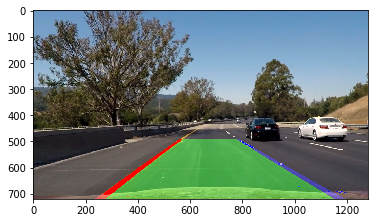

In [35]:
processed_img = cv2.cvtColor(cv2.imread(test_img_list[-1]), cv2.COLOR_BGR2RGB)
processed_img[(inv_sign_img == 255)] = inv_warped[(inv_sign_img == 255)]
plt.imshow(processed_img)
plt.show()

In [163]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [233]:
# Lfinder = FLane.Lane()
Lfinder = Lane()
cover = np.zeros_like(xFilter)
cover[:, 150:1200] = 1
def processing_image(image) :
    und_image = calibration.undistort(image)
    warped_image = cv2.warpPerspective(und_image, M, (img.shape[1], img.shape[0]))
    _, _ = gradF.compute_mag_grad(warped_image, 3)
#     _ = gradF.compute_dir(warped_image, 21)

    xFilter = gradF.getXgradFilter()
    yFilter = gradF.getYgradFilter()
#     magFilter = gradF.getMagFilter()
#     dirFilter = gradF.getDirFilter()
    
    colorFilter = colorF.getColorFilter(warped_image, (100, 255))
    
    xFilter[(cover == 0)] = 0
    yFilter[(cover == 0)] = 0
    colorFilter[(cover == 0)] = 0
    
    combine_Bin_image = np.zeros_like(colorFilter)
    combine_Bin_image[(((xFilter == 1) & (yFilter ==1))==1) | (colorFilter == 1)] = 1
    
    diff_dis, mean_r = Lfinder.processing(combine_Bin_image, warped_image, _visualization = True)
#     print (diff_dis)
    
    
    inv_warped_image = cv2.warpPerspective(Lfinder.result, inv_M, (image.shape[1], image.shape[0]))
    und_image[(inv_sign_img == 255)] = inv_warped_image[(inv_sign_img == 255)]
    
    text = 'on the center.'
    
    if (diff_dis > 0) :
        text = 'right of center : %f m'%(diff_dis)
    elif (diff_dis < 0) :
        text = 'left of center : %f m'%(-diff_dis)
        
    cv2.putText(und_image, ('Radius of Curvature : %d m'%(np.int(mean_r))), (50,70), cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(und_image, text, (50,150), cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 0), 2, cv2.LINE_AA)
#     cv2.putText(Lfinder.result, 'diffs_right')
    
#     cv2.putText(Lfinder.result, ('left 0: %f, 1: %f, 2: %f'%(Lfinder.diffs_left[0], Lfinder.diffs_left[1], Lfinder.diffs_left[2])), (50,70), cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 0), 2, cv2.LINE_AA)
#     cv2.putText(Lfinder.result, ('right 0: %f, 1: %f, 2: %f'%(Lfinder.diffs_right[0], Lfinder.diffs_right[1], Lfinder.diffs_right[2])), (50,150), cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 0), 2, cv2.LINE_AA)
    
#     text_l = 'F'
#     text_r = 'F'
#     if (Lfinder.detected_left):
#         text_l = 'T'
#     if (Lfinder.detected_right):
#         text_r = 'T'
    
#     cv2.putText(Lfinder.result, text_l, (50,70), cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 0), 2, cv2.LINE_AA)
#     cv2.putText(Lfinder.result, text_r, (50,150), cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 0), 2, cv2.LINE_AA)

    
    
    return und_image
#     return Lfinder.result
#     combine_Bin_image = combine_Bin_image * 255
#     return np.dstack((combine_Bin_image, combine_Bin_image, combine_Bin_image))

In [234]:
output_dir = 'output_images/project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')#.subclip(17, 37)
output_clip = clip1.fl_image(processing_image)
%time output_clip.write_videofile(output_dir, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4











  0%|          | 0/1261 [00:00<?, ?it/s]








  0%|          | 1/1261 [00:00<03:19,  6.33it/s]








  0%|          | 2/1261 [00:00<03:27,  6.07it/s]








  0%|          | 3/1261 [00:00<03:25,  6.13it/s]








  0%|          | 4/1261 [00:00<03:21,  6.24it/s]








  0%|          | 5/1261 [00:00<03:22,  6.21it/s]








  0%|          | 6/1261 [00:01<03:36,  5.81it/s]








  1%|          | 7/1261 [00:01<04:02,  5.17it/s]








  1%|          | 8/1261 [00:01<04:31,  4.62it/s]








  1%|          | 9/1261 [00:01<05:03,  4.13it/s]








  1%|          | 10/1261 [00:02<05:22,  3.88it/s]








  1%|          | 11/1261 [00:02<05:35,  3.73it/s]








  1%|          | 12/1261 [00:02<05:11,  4.00it/s]








  1%|          | 13/1261 [00:02<04:46,  4.35it/s]








  1%|          | 14/1261 [00:03<04:46,  4.35it/s]








  1%|          | 15/1261 [00:03<04:33,  4.56it/s]








  1%|▏         | 16/1261 [00:03<04:37,  4.49it/s]








  1%|▏         | 17/126

 15%|█▌        | 191/1261 [00:31<02:43,  6.54it/s]








 15%|█▌        | 192/1261 [00:32<02:46,  6.41it/s]








 15%|█▌        | 193/1261 [00:32<02:44,  6.50it/s]








 15%|█▌        | 194/1261 [00:32<02:45,  6.46it/s]








 15%|█▌        | 195/1261 [00:32<02:42,  6.55it/s]








 16%|█▌        | 196/1261 [00:32<02:47,  6.35it/s]








 16%|█▌        | 197/1261 [00:32<02:45,  6.43it/s]








 16%|█▌        | 198/1261 [00:32<02:43,  6.51it/s]








 16%|█▌        | 199/1261 [00:33<02:42,  6.54it/s]








 16%|█▌        | 200/1261 [00:33<02:43,  6.48it/s]








 16%|█▌        | 201/1261 [00:33<02:41,  6.55it/s]








 16%|█▌        | 202/1261 [00:33<02:41,  6.57it/s]








 16%|█▌        | 203/1261 [00:33<02:38,  6.66it/s]








 16%|█▌        | 204/1261 [00:33<02:44,  6.44it/s]








 16%|█▋        | 205/1261 [00:34<02:42,  6.49it/s]








 16%|█▋        | 206/1261 [00:34<02:40,  6.58it/s]








 16%|█▋        | 207/1261 [00:34<02:39,  6.60it/s]







 30%|███       | 381/1261 [01:01<02:13,  6.59it/s]








 30%|███       | 382/1261 [01:01<02:17,  6.39it/s]








 30%|███       | 383/1261 [01:01<02:15,  6.47it/s]








 30%|███       | 384/1261 [01:01<02:13,  6.57it/s]








 31%|███       | 385/1261 [01:01<02:11,  6.65it/s]








 31%|███       | 386/1261 [01:01<02:15,  6.45it/s]








 31%|███       | 387/1261 [01:01<02:14,  6.52it/s]








 31%|███       | 388/1261 [01:02<02:11,  6.63it/s]








 31%|███       | 389/1261 [01:02<02:11,  6.61it/s]








 31%|███       | 390/1261 [01:02<02:13,  6.52it/s]








 31%|███       | 391/1261 [01:02<02:12,  6.56it/s]








 31%|███       | 392/1261 [01:02<02:12,  6.54it/s]








 31%|███       | 393/1261 [01:02<02:10,  6.63it/s]








 31%|███       | 394/1261 [01:03<02:14,  6.45it/s]








 31%|███▏      | 395/1261 [01:03<02:13,  6.48it/s]








 31%|███▏      | 396/1261 [01:03<02:11,  6.56it/s]








 31%|███▏      | 397/1261 [01:03<02:09,  6.67it/s]







 45%|████▌     | 571/1261 [01:30<01:45,  6.51it/s]








 45%|████▌     | 572/1261 [01:30<01:48,  6.35it/s]








 45%|████▌     | 573/1261 [01:30<01:46,  6.45it/s]








 46%|████▌     | 574/1261 [01:30<01:45,  6.53it/s]








 46%|████▌     | 575/1261 [01:30<01:44,  6.59it/s]








 46%|████▌     | 576/1261 [01:30<01:46,  6.44it/s]








 46%|████▌     | 577/1261 [01:30<01:44,  6.53it/s]








 46%|████▌     | 578/1261 [01:31<01:43,  6.61it/s]








 46%|████▌     | 579/1261 [01:31<01:43,  6.61it/s]








 46%|████▌     | 580/1261 [01:31<01:45,  6.47it/s]








 46%|████▌     | 581/1261 [01:31<01:43,  6.54it/s]








 46%|████▌     | 582/1261 [01:31<01:43,  6.59it/s]








 46%|████▌     | 583/1261 [01:31<01:41,  6.67it/s]








 46%|████▋     | 584/1261 [01:32<01:44,  6.51it/s]








 46%|████▋     | 585/1261 [01:32<01:43,  6.53it/s]








 46%|████▋     | 586/1261 [01:32<01:42,  6.58it/s]








 47%|████▋     | 587/1261 [01:32<01:41,  6.62it/s]







 60%|██████    | 761/1261 [01:59<01:19,  6.33it/s]








 60%|██████    | 762/1261 [01:59<01:17,  6.43it/s]








 61%|██████    | 763/1261 [01:59<01:16,  6.55it/s]








 61%|██████    | 764/1261 [01:59<01:16,  6.50it/s]








 61%|██████    | 765/1261 [01:59<01:16,  6.51it/s]








 61%|██████    | 766/1261 [01:59<01:14,  6.60it/s]








 61%|██████    | 767/1261 [02:00<01:14,  6.64it/s]








 61%|██████    | 768/1261 [02:00<01:15,  6.53it/s]








 61%|██████    | 769/1261 [02:00<01:14,  6.60it/s]








 61%|██████    | 770/1261 [02:00<01:13,  6.67it/s]








 61%|██████    | 771/1261 [02:00<01:12,  6.74it/s]








 61%|██████    | 772/1261 [02:00<01:13,  6.64it/s]








 61%|██████▏   | 773/1261 [02:00<01:13,  6.66it/s]








 61%|██████▏   | 774/1261 [02:01<01:12,  6.70it/s]








 61%|██████▏   | 775/1261 [02:01<01:12,  6.72it/s]








 62%|██████▏   | 776/1261 [02:01<01:15,  6.43it/s]








 62%|██████▏   | 777/1261 [02:01<01:14,  6.50it/s]







 75%|███████▌  | 951/1261 [02:28<00:47,  6.57it/s]








 75%|███████▌  | 952/1261 [02:28<00:46,  6.58it/s]








 76%|███████▌  | 953/1261 [02:28<00:46,  6.65it/s]








 76%|███████▌  | 954/1261 [02:28<00:47,  6.50it/s]








 76%|███████▌  | 955/1261 [02:28<00:46,  6.53it/s]








 76%|███████▌  | 956/1261 [02:28<00:46,  6.57it/s]








 76%|███████▌  | 957/1261 [02:29<00:45,  6.64it/s]








 76%|███████▌  | 958/1261 [02:29<00:47,  6.44it/s]








 76%|███████▌  | 959/1261 [02:29<00:46,  6.47it/s]








 76%|███████▌  | 960/1261 [02:29<00:46,  6.54it/s]








 76%|███████▌  | 961/1261 [02:29<00:45,  6.63it/s]








 76%|███████▋  | 962/1261 [02:29<00:46,  6.46it/s]








 76%|███████▋  | 963/1261 [02:29<00:45,  6.54it/s]








 76%|███████▋  | 964/1261 [02:30<00:44,  6.61it/s]








 77%|███████▋  | 965/1261 [02:30<00:44,  6.69it/s]








 77%|███████▋  | 966/1261 [02:30<00:45,  6.46it/s]








 77%|███████▋  | 967/1261 [02:30<00:44,  6.54it/s]







 90%|█████████ | 1139/1261 [02:57<00:18,  6.58it/s]








 90%|█████████ | 1140/1261 [02:57<00:18,  6.62it/s]








 90%|█████████ | 1141/1261 [02:57<00:17,  6.73it/s]








 91%|█████████ | 1142/1261 [02:57<00:18,  6.61it/s]








 91%|█████████ | 1143/1261 [02:58<00:17,  6.68it/s]








 91%|█████████ | 1144/1261 [02:58<00:17,  6.76it/s]








 91%|█████████ | 1145/1261 [02:58<00:17,  6.79it/s]








 91%|█████████ | 1146/1261 [02:58<00:17,  6.60it/s]








 91%|█████████ | 1147/1261 [02:58<00:17,  6.67it/s]








 91%|█████████ | 1148/1261 [02:58<00:16,  6.74it/s]








 91%|█████████ | 1149/1261 [02:58<00:16,  6.79it/s]








 91%|█████████ | 1150/1261 [02:59<00:16,  6.64it/s]








 91%|█████████▏| 1151/1261 [02:59<00:16,  6.68it/s]








 91%|█████████▏| 1152/1261 [02:59<00:16,  6.68it/s]








 91%|█████████▏| 1153/1261 [02:59<00:16,  6.72it/s]








 92%|█████████▏| 1154/1261 [02:59<00:16,  6.59it/s]








 92%|█████████▏| 1155/1261 [02:59<00:15,

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 3min 9s, sys: 41.1 s, total: 3min 51s
Wall time: 3min 16s


In [66]:
HTML("""
<video width="960" height="540" controls>
  <source = src="{0}">
</video>
""".format(output_dir))

In [ ]:
# 

In [43]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

class Lane :
    def __init__(self, _nwindows = 9, _margin = 80, _minpix = 40, _n_iter = 10) :
        # HYPERPARAMETERS
        # Choose the number of sliding windows
        # Set the width of the windows +/- margin
        # Set minimum number of pixels found to recenter window
        self.nwindows = _nwindows
        self.margin = _margin
        self.minpix = _minpix

        self.Line_thinkness = 15

        self.n_iter = _n_iter

        self.ploty = None

        # Define conversions in x and y from pixels space to meters
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/650 # meters per pixel in x dimension

        self.out_img = []
        self.histogram = []
        self.result = []

        # was the line detected in the last iteration?
        self.detected_left = False  
        self.detected_right = False
        # x values of the last n fits of the line
        # self.recent_xfitted = [] 
        self.recent_xfitted_left = []
        self.recent_xfitted_right = []
        #average x values of the fitted line over the last n iterations
        self.bestx_left = None  
        self.bestx_right = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit_left = None
        self.best_fit_right = None
        #polynomial coefficients for the most recent fit
        self.current_fit_left = [np.array([False])]  
        self.current_fit_right = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        self.diff_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs_left = np.array([0,0,0], dtype='float') 
        self.diffs_right = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        # self.allx = None  
        #y values for detected line pixels
        # self.ally = None  

    def find_lane_pixels(self, _img_b, _draw_img, _visualization = False) :
        # Take a histogram of the bottom half of the image
        histogram = np.sum(_img_b[_img_b.shape[0]//2:,:], axis=0)
        self.histogram = np.copy(histogram)
        # Create an output image to draw on and visualize the result
        if (_visualization) :
            out_img = np.dstack((_img_b, _img_b, _img_b))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Set height of windows - based on self.nwindows above and image shape
        window_height = np.int(_img_b.shape[0]//self.nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = _img_b.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in self.nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = _img_b.shape[0] - (window+1)*window_height
            win_y_high = _img_b.shape[0] - window*window_height
            ### TO-DO: Find the four below boundaries of the window ###
            win_xleft_low = leftx_current - self.margin  # Update this
            win_xleft_high = leftx_current + self.margin  # Update this
            win_xright_low = rightx_current - self.margin  # Update this
            win_xright_high = rightx_current + self.margin  # Update this
            
            # Draw the windows on the visualization image
#             if (_visualization) :
#                 cv2.rectangle(_draw_img,(win_xleft_low,win_y_low),
#                 (win_xleft_high,win_y_high),(0,255,0), 2) 
#                 cv2.rectangle(_draw_img,(win_xright_low,win_y_low),
#                 (win_xright_high,win_y_high),(0,255,0), 2) 
            
            ### TO-DO: Identify the nonzero pixels in x and y within the window ###
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            ### TO-DO: If you found > self.minpix pixels, recenter next window ###
            ### (`right` or `leftx_current`) on their mean position ###
            # pass # Remove this when you add your function
            if (len(good_left_inds) > self.minpix) :
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

#         if (_visualization) :
#             self.out_img = np.copy(_draw_img)

        return leftx, lefty, rightx, righty


    def fit_polynomial(self, _img_b, _leftx, _lefty, 
                            _rightx, _righty, 
                            _visualization = False) :
        ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
        left_fit = np.polyfit(_lefty, _leftx, 2)
        right_fit = np.polyfit(_righty, _rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, _img_b.shape[0]-1, _img_b.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##
#         if (_visualization) :
            # Colors in the left and right lane regions
#             self.out_img[_lefty, _leftx] = [255, 0, 0]
#             self.out_img[_righty, _rightx] = [0, 0, 255]

            # Plots the left and right polynomials on the lane lines
#             plt.plot(left_fitx, ploty, color='yellow')
#             plt.plot(right_fitx, ploty, color='yellow')
        
        return left_fitx, right_fitx, left_fit, right_fit

    def search_around_poly(self, _img_b, _draw_img, _left_fit, _right_fit, 
                            _visualization = False) :
        # Grab activated pixels
        nonzero = _img_b.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        left_lane_inds = (nonzerox > (_left_fit[0] * nonzeroy ** 2 + _left_fit[1] * nonzeroy + _left_fit[2] - self.margin)) & \
                        (nonzerox < (_left_fit[0] * nonzeroy ** 2 + _left_fit[1] * nonzeroy + _left_fit[2] + self.margin))
        right_lane_inds = (nonzerox > (_right_fit[0] * nonzeroy ** 2 + _right_fit[1] * nonzeroy + _right_fit[2] - self.margin)) & \
                        (nonzerox < (_right_fit[0] * nonzeroy ** 2 + _right_fit[1] * nonzeroy + _right_fit[2] + self.margin))
        
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit new polynomials
        left_fitx, right_fitx, left_fit, right_fit = self.fit_polynomial(_img_b, leftx, lefty, 
                                    rightx, righty, _visualization = _visualization)
        ploty = np.linspace(0, _img_b.shape[0]-1, _img_b.shape[0])
        
        

        ## Visualization ##
        # Show search margin
        
        if _visualization :
            # Create an image to draw on and an image to show the selection window
            # out_img = np.dstack((_img_b, _img_b, _img_b))*255
            window_img = np.zeros_like(_draw_img)
            # Color in left and right line pixels
            _draw_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            _draw_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-self.margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+self.margin, 
                                    ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-self.margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+self.margin, 
                                    ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            result = cv2.addWeighted(_draw_img, 1, window_img, 0.3, 0)
            
            # Plot the polynomial lines onto the image
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            ## End visualization steps ##
            
            self.result = np.copy(result)
        

        return left_fitx, right_fitx, left_fit, right_fit
    
    def visualize(self, _draw_img, bestx_left, bestx_right) :
        # Create an image to draw on and an image to show the selection window
        # out_img = np.dstack((_img_b, _img_b, _img_b))*255

#         self.bestx_left = np.mean(self.recent_xfitted_left, 0)
#         self.bestx_right =  np.mean(self.recent_xfitted_right, 0)

        window_img = np.zeros_like(_draw_img)
        # Color in left and right line pixels
        # _draw_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        # _draw_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([bestx_left-self.Line_thinkness, self.ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([bestx_left+self.Line_thinkness, 
                                self.ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([bestx_right-self.Line_thinkness, self.ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([bestx_right+self.Line_thinkness, 
                                self.ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        center_area_pts = np.hstack((left_line_window2, right_line_window1))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (255, 0, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 0, 255))
        cv2.fillPoly(window_img, np.int_([center_area_pts]), (0, 255, 0))

        result = cv2.addWeighted(_draw_img, 1, window_img, 0.4, 0)

        # Plot the polynomial lines onto the image
        # plt.plot(left_fitx, ploty, color='yellow')
        # plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##

        self.result = np.copy(result)

    def measure_curvature_real(self, _img_b, _left_fitx, _right_fitx):
        '''
        Calculates the curvature of polynomial functions in meters.
        '''
        ploty = np.linspace(0, _img_b.shape[0]-1, _img_b.shape[0])
        left_fit_cr = np.polyfit(ploty * self.ym_per_pix, _left_fitx * self.xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty * self.ym_per_pix, _right_fitx * self.xm_per_pix, 2)

        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        
        y_eval = np.max(ploty)

        ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * self.ym_per_pix+ left_fit_cr[1])**2 )**1.5) / (2 * np.abs(left_fit_cr[0]))
        right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * self.ym_per_pix + right_fit_cr[1])**2 )**1.5) / (2 * np.abs(right_fit_cr[0]))

        return left_curverad, right_curverad

    def processing(self, _img_b, _draw_img, _visualization = False) :
        if ((self.detected_left & self.detected_right)) :
            left_fitx, right_fitx, left_fit, right_fit = self.search_around_poly(_img_b, _draw_img, self.current_fit_left, self.current_fit_right
                                , _visualization = _visualization)
            
            self.diffs_left = np.abs(self.current_fit_left - left_fit)
            self.diffs_right = np.abs(self.current_fit_right - right_fit)
            
            if ((self.diffs_left[0] > 0.001) or (self.diffs_left[1] > 1.0) or (self.diffs_left[2] > 80.0)) :
                self.detected_left = False
#                 self.recent_xfitted_left = []
            else :
                self.recent_xfitted_left.append(left_fitx)
                
            if (self.diffs_right[0] > 0.001 or self.diffs_right[1] > 1.0 or self.diffs_right[2] > 80.0) :
                self.detected_right = False 
#                 self.recent_xfitted_right = []
            else :
                self.recent_xfitted_right.append(right_fitx)
                
            self.getBest()
                
#             left_curverad, right_curverad = self.measure_curvature_real(_img_b, left_fitx, right_fitx)
            left_curverad, right_curverad = self.measure_curvature_real(_img_b, self.recent_xfitted_left[-1], self.recent_xfitted_right[-1])
            
#             self.recent_xfitted_left.append(left_fitx)
#             self.recent_xfitted_right.append(right_fitx)

#             self.visualize(_draw_img, self.bestx_left, self.bestx_right)

#             def getBest(self) :
#         self.bestx_left = np.mean(self.recent_xfitted_left, 0)
#         self.bestx_right =  np.mean(self.recent_xfitted_right, 0)

#         self.best_fit_left = np.polyfit(self.ploty, self.bestx_left, 2)
#         self.best_fit_right = np.polyfit(self.ploty, self.bestx_right, 2)

            self.current_fit_left = np.copy(self.best_fit_left) 
            self.current_fit_right = np.copy(self.best_fit_right)  

            _l = self.best_fit_left[0] * (720.0 ** 2) + self.best_fit_left[1] * 720.0 + self.best_fit_left[2]
            _r = self.best_fit_right[0] * (720.0 ** 2) + self.best_fit_right[1] * 720.0 + self.best_fit_right[2]
            self.diff_pos = (_l + _r) / 2 - self.line_base_pos

#             self.line_base_pos = ((right_curverad - left_curverad) / 2) + left_curverad
#             if (self.line_base_pos == None) :
#                 self.line_base_pos = ((right_curverad - left_curverad) / 2) + left_curverad
#             else :
#                 self.diff_pos = ((right_curverad - left_curverad) / 2) + left_curverad - self.line_base_pos

            self.radius_of_curvature = (left_curverad, right_curverad) 

            
            if (len(self.recent_xfitted_left) > self.n_iter) :
                self.recent_xfitted_left.remove(self.recent_xfitted_left[0])
            if (len(self.recent_xfitted_right) > self.n_iter) :   
                self.recent_xfitted_right.remove(self.recent_xfitted_right[0])
            
#             self.getBest()

        else :
            self.ploty = np.linspace(0, _img_b.shape[0]-1, _img_b.shape[0])
            leftx, lefty, rightx, righty = self.find_lane_pixels(_img_b, _draw_img, _visualization = _visualization)
            left_fitx, right_fitx, left_fit, right_fit = self.fit_polynomial(_img_b, leftx, lefty, 
                                                            rightx, righty, _visualization=_visualization)
#             left_curverad, right_curverad = self.measure_curvature_real(_img_b, left_fitx, right_fitx)
            
            if (len(self.recent_xfitted_left) > 0) :
                self.diffs_left = np.abs(self.current_fit_left - left_fit)
#                 print (self.diffs_left)
                if (self.diffs_left[0] > 0.001 or self.diffs_left[1] > 1.0 or self.diffs_left[2] > 80.0) :
                    self.detected_left = False
#                     self.recent_xfitted_left = []
                else :
                    self.recent_xfitted_left.append(left_fitx)
            else :
                self.recent_xfitted_left.append(left_fitx)
                self.detected_left = True
                    
            if (len(self.recent_xfitted_right) > 0) :
                self.diffs_right = np.abs(self.current_fit_right - right_fit)
#                 print ()
                if (self.diffs_right[0] > 0.001 or self.diffs_right[1] > 1.0 or self.diffs_right[2] > 80.0) :
                    self.detected_right = False
                else :
                    self.recent_xfitted_right.append(right_fitx)
            else :
                self.recent_xfitted_right.append(right_fitx)
                self.detected_right = True
            
            self.getBest()
                
#             left_curverad, right_curverad = self.measure_curvature_real(_img_b, left_fitx, right_fitx)
            left_curverad, right_curverad = self.measure_curvature_real(_img_b, self.recent_xfitted_left[-1], self.recent_xfitted_right[-1])
            
#             self.recent_xfitted_left.append(left_fitx)
#             self.recent_xfitted_right.append(right_fitx)

#             self.visualize(_draw_img, self.bestx_left, self.bestx_right)
            
#             self.visualize(_draw_img, left_fitx, right_fitx)

#             self.recent_xfitted_left.append(left_fitx)
#             self.recent_xfitted_right.append(right_fitx)

            self.current_fit_left = np.copy(self.best_fit_left) 
            self.current_fit_right = np.copy(self.best_fit_right)
            
            if (self.line_base_pos == None) :
                _l = self.best_fit_left[0] * (720.0 ** 2) + self.best_fit_left[1] * 720.0 + self.best_fit_left[2]
                _r = self.best_fit_right[0] * (720.0 ** 2) + self.best_fit_right[1] * 720.0 + self.best_fit_right[2]
                self.line_base_pos = (_l + _r) / 2
                self.diff_pos = 0
            else :
                _l = self.best_fit_left[0] * (720.0 ** 2) + self.best_fit_left[1] * 720.0 + self.best_fit_left[2]
                _r = self.best_fit_right[0] * (720.0 ** 2) + self.best_fit_right[1] * 720.0 + self.best_fit_right[2]
                self.diff_pos = (_l + _r) / 2 - self.line_base_pos
                
                
            self.radius_of_curvature = (left_curverad, right_curverad) 
#             left_fitx, right_fitx, left_fit, right_fit = self.search_around_poly(_img_b, _draw_img, self.current_fit_left, self.current_fit_right
#                                 , _visualization = _visualization)
            if (len(self.recent_xfitted_left) > self.n_iter) :
                self.recent_xfitted_left.remove(self.recent_xfitted_left[0])
            if (len(self.recent_xfitted_right) > self.n_iter) :   
                self.recent_xfitted_right.remove(self.recent_xfitted_right[0])
    
        if (self.line_base_pos != None) :
            return self.diff_pos * self.xm_per_pix, np.mean(self.radius_of_curvature)
#             self.getBest()
        

    def getBest(self) :
        self.bestx_left = np.mean(self.recent_xfitted_left, 0)
        self.bestx_right =  np.mean(self.recent_xfitted_right, 0)
    
#         print (self.ploty.shape, self.bestx_left.shape, self.bestx_right.shape)
        
        self.best_fit_left = np.polyfit(self.ploty, self.bestx_left, 2)
        self.best_fit_right = np.polyfit(self.ploty, self.bestx_right, 2)

        # left_fitx point 
        # left_fit coeff

        # was the line detected in the last iteration?
        # self.detected = False  
        # x values of the last n fits of the line
        # self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        # self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        # self.best_fit = None  
        #polynomial coefficients for the most recent fit
        # self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        # self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        # self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        # self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        # self.allx = None  
        #y values for detected line pixels
        # self.ally = None 


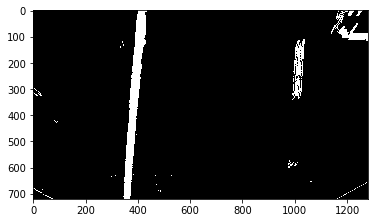

In [24]:
plt.imshow(combine, cmap='gray')
plt.show()

In [86]:
a = np.array(range(5))
b = (a + 5) / 2

In [87]:
b


array([2.5, 3. , 3.5, 4. , 4.5])

In [88]:
np.abs(a - b)

array([2.5, 2. , 1.5, 1. , 0.5])